# The spatial analysis of Airbnb professionalisation in London

## CASA0013: Foundations of Spatial Data Science

### Student Ids: 22081116, 22232922, 22223272, 22182976

This code reproduces the process of our analysis of London housing specialization, including data acquisition, data processing, spatial analysis and visualization.

## Preamble

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import esda
import libpysal as lps
from shapely.geometry import Point
import contextily as ctx
import contextily
import requests
import zipfile
import re
import os
import pickle as pk
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap



<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


## 1. Load data

Firstly, read in Airbnb listing (might take a while):

In [2]:
url1 = 'http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/data/listings.csv.gz'
airbnb_origin2022 = pd.read_csv(url1, compression='gzip', low_memory=False)

Then, import London Ward data:

In [3]:
url2 = 'https://github.com/korentinchen/fsdsgroupwork/raw/main/data/ward_new.gpkg'
ward = gpd.read_file(os.path.join(url2), driver='GPKG')
ward = ward.to_crs('epsg:27700')
ward

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837...."
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114...."
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490...."
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063...."
...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391...."
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988...."
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712...."
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377...."


## 2.Data processing

### 2.1 Clean names

We use a function to clean uo column names in the Airbnb data frame:

In [4]:
# credit by https://gist.github.com/burkesquires/75aeebf4554e9fa427d14354d7fe048c
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscore
        new_column_names.append(new_col)

    df.columns = new_column_names
clean_dataframe_column_names(airbnb_origin2022)

then we select the columns we need :

In [5]:
airbnb2022 = airbnb_origin2022[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

### 2.2 Select professional listings

We try to select the professional listings from the general table:

In [6]:
airbnbprof2022 = airbnb2022[airbnb2022['host_listings_count']>1 ]

### 2.3 Aggregating listings by ward

Convert two table coordinates to points:

In [7]:
#prof
gdfprof = gpd.GeoDataFrame(airbnbprof2022, 
      geometry=gpd.points_from_xy(airbnbprof2022['longitude'], airbnbprof2022['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')

#total
gdftotal = gpd.GeoDataFrame(airbnb2022, 
      geometry=gpd.points_from_xy(airbnb2022['longitude'], airbnb2022['latitude'], crs='epsg:4326'))
gdftotal = gdftotal.to_crs('epsg:27700')

Use spatial join to connect points and wards：

In [8]:
# wl == Ward Listings
wlprof = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wltotal = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Use group by to count the number of points within each ward:

In [9]:
#wl group
wlprof = wlprof.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wlprof.columns.values
cols[1] = 'wlprofcount'
wlprof.columns = cols

wltotal = wltotal.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wltotal.columns.values
cols[1] = 'wltotalcount'
wltotal.columns = cols

Then we calculate the percentage of professinonal listings and add it to the geodataframe:

In [10]:
warddata=ward.merge(wlprof, on='GSS_CODE', how='left')
warddata=warddata.merge(wltotal, on='GSS_CODE', how='left')
warddata['wlprofcount'].fillna(0)
warddata['wlprofcount'].fillna(0)
warddata.eval('wlpercent = wlprofcount / wltotalcount' , inplace=True)

## 3.Descriptive statistics

In [12]:
#The profit of the hosts with 1listing (because the final calculation is a ratio, so assume that the price is the profit)
host20p= airbnb2022[airbnb2022['host_listings_count']==1 ]
host20p = host20p['price'].sum()
#The number of hosts with a single listing
singlelisthosts = airbnb2022[airbnb2022['host_listings_count']==1]
singlelisthosts_num = singlelisthosts.groupby(['host_id'])
#Total number of host listings with 1 listing
host1ln= airbnb2022[airbnb2022['host_listings_count']==1 ]

We could get:
- the proportion of profit of 1 listging hosts:0.35
- the proportion of hostnumber of 1 listing: 0.77
- the proportion of listingnumber of 1 listing:0.50

In [13]:
#The profit of the hosts with 2-5 listing
host25= airbnb2022[(airbnb2022['host_listings_count']>1) & (airbnb2022['host_listings_count']<6) ]
host25['price'].sum()
#he number of hosts with a 2-5 listing
host25 = airbnb2022[(airbnb2022['host_listings_count']>1) & (airbnb2022['host_listings_count']<6)  ]
host25 = host25.groupby(['host_id'])
#Total number of host listings with 2-5 listing
host25LN = airbnb2022[(airbnb2022['host_listings_count']>1) & (airbnb2022['host_listings_count']<6)  ]

We could get:
- the proportion of profit of 2-5 listging hosts:0.22
- the proportion of hostnumber of 2-5 listing: 0.20
- the proportion of listingnumber of 2-5 listing:0.27

In [14]:
#The profit of the hosts with 6-20 listing
host620p = airbnb2022[(airbnb2022['host_listings_count']>5) & (airbnb2022['host_listings_count']<21)  ]
host620p['price'].sum()
#he number of hosts with a 6-20 listing
host620 = airbnb2022[(airbnb2022['host_listings_count']>5) & (airbnb2022['host_listings_count']<21)  ]
host620 = host620.groupby(['host_id'])
#Total number of host listings with 6-20 listing
host620LN = airbnb2022[(airbnb2022['host_listings_count']>5) & (airbnb2022['host_listings_count']<21)  ]

We could get:
- the proportion of profit of 6-20 listging hosts:0.14
- the proportion of hostnumber of 6-20 listing: 0.025
- the proportion of listingnumber of 6-20 listing:0.11

In [15]:
#The profit of the hosts with 20 +listing
host20p = airbnb2022[airbnb2022['host_listings_count']>20 ]
host20p['price'].sum()
##he number of hosts with 20+ listing
host20 = airbnb2022[airbnb2022['host_listings_count']>20 ]
host20 = host20.groupby(['host_id'])
#Total number of host listings with 20+ listing
host20ln= airbnb2022[airbnb2022['host_listings_count']>20 ]

We could get:
- the proportion of profit above 20 listging hosts:0.29
- the proportion of hostnumber above 20 listing: 0.005
- the proportion of listingnumber above 20 listing:0.12

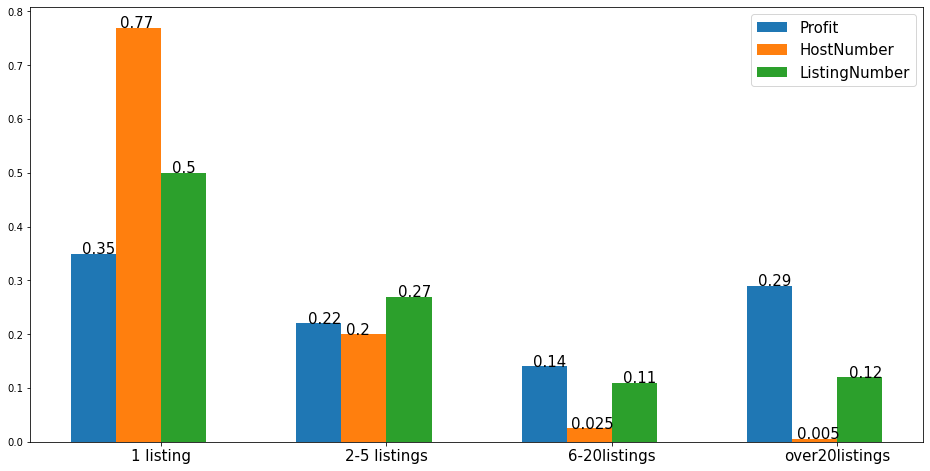

In [16]:
#build dataset
y1 = [0.35,0.22,0.14,0.29]
y2 = [0.77,0.20,0.025,0.005]
y3 = [0.50,0.27,0.11,0.12]
label = ['1 listing','2-5 listings','6-20listings', 'over20listings']
#Set the breadth of the histogram
width = 0.2
x = np.arange(len(label))  
#plot
plt.figure(figsize=(16,8))

plt.bar(x=x-0.2,height=y1,width=width,label='Profit')
plt.bar(x=x ,height=y2,width=width,label='HostNumber')
plt.bar(x=x+0.2,height=y3,width=width,label='ListingNumber')

#add data label
for x_value,y_value in zip(x,y1):
    plt.text(x=x_value-0.25,y=y_value,s=y_value,fontsize=15)

for x_value,y_value in zip(x,y2):
    plt.text(x=x_value-0.08,y=y_value,s=y_value,fontsize=15)
    
for x_value,y_value in zip(x,y3):
    plt.text(x=x_value+0.15,y=y_value,s=y_value,fontsize=15)
#lengend
plt.legend(fontsize=15)
plt.xticks(x+width/2, label,fontsize=15)
plt.show()

## 4.Spatial distribution of professional listings in London

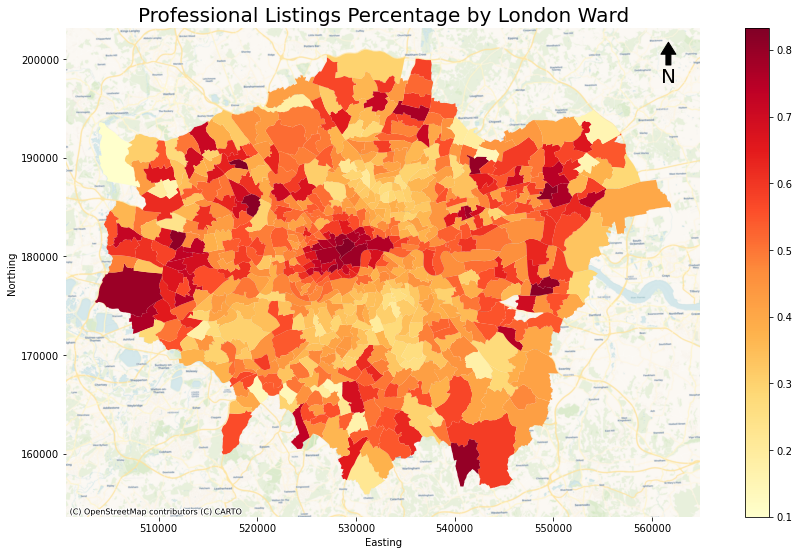

In [18]:
fig, ax = plt.subplots(figsize =(16,9))

warddata.plot(ax=ax, column = 'wlpercent', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings Percentage by London Ward',fontsize = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
x, y, arrow_length = 0.95, 0.97, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)

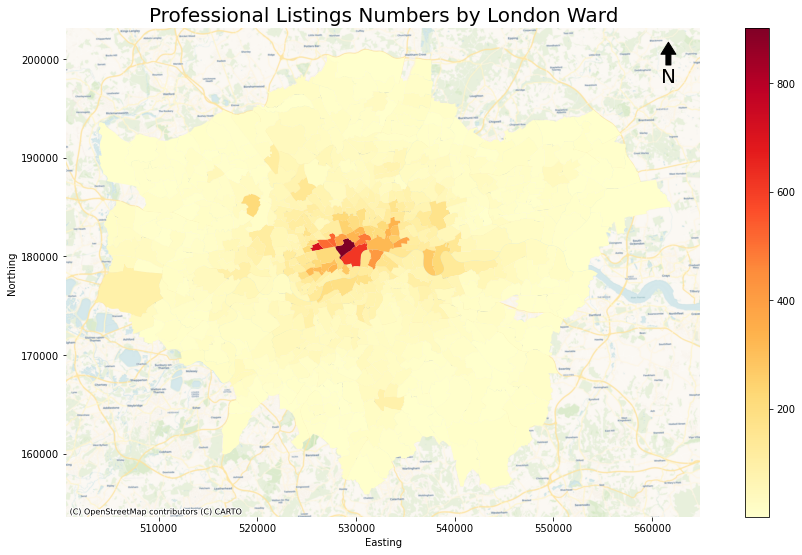

In [19]:
fig, ax = plt.subplots(figsize =(16,9))

warddata.plot(ax=ax, column = 'wlprofcount', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings Numbers by London Ward',fontsize = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
x, y, arrow_length = 0.95, 0.97, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)

## 5.Moran's I

### 5.1Create Queen Neighbor

We created a neighbours matrix Wij using the Queen‘s contiguous relationship:

In [20]:
wq = lps.weights.Queen.from_dataframe(ward)   # Quuen's neighours matrix
wq.transform = 'r'  # The transform our weights to be row-standardised.

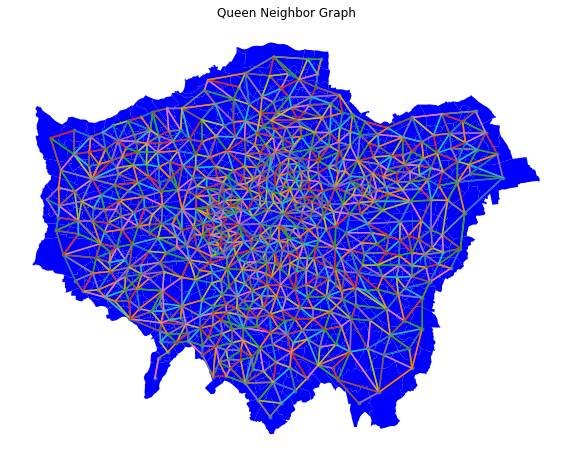

In [21]:
# Create the centroil of each ward

centroids = ward.geometry.centroid 
ax = ward.plot(figsize=(10, 10),color='blue')
plt.plot(centroids.x, centroids.y, '.')
for k, neighs in wq.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment.x, segment.y, '-')
plt.title('Queen Neighbor Graph')
plt.axis('off')
plt.show()

In [22]:
warddata_m=warddata[["GSS_CODE","wlpercent","geometry"]]

# Replace the na value in interested field 'wlpercent' with 0
warddata_m['wlpercent'] = warddata_m['wlpercent'].fillna(0)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
# Run the Global Moran'I test and focus on the Moran's I value and p-value. 
mi=esda.Moran(warddata_m[["wlpercent"]],wq)
print("Moran's I value：",mi.I)
print("random Ztest：",mi.z_rand)
print("random Ztest pvalue: ", mi.p_rand)
print("normal Ztest：",mi.z_norm)
print("normal Ztest Pvalue：",mi.p_norm)

Moran's I value： 0.33463037372108767
random Ztest： 14.21739214221526
random Ztest pvalue:  0.0
normal Ztest： 14.216305657040298
normal Ztest Pvalue： 0.0


### 5.2Local Moran I

In [24]:
y = warddata_m['wlpercent'].values
# Run the Local Moran I 
moran_loc = Moran_Local(y, wq)

We chose p=0.1 threhold, significane level at 90%. Visualise the results of local Moran' I on the map:

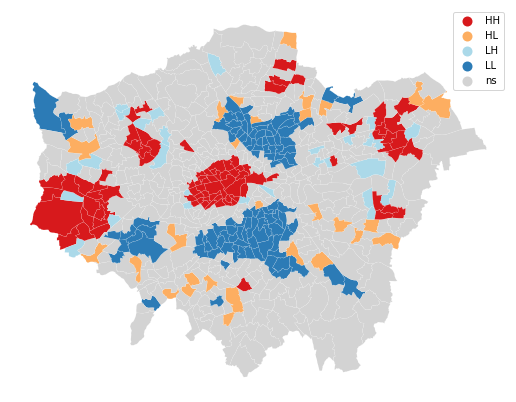

In [25]:
loc_moran_df = pd.DataFrame({'name':warddata_m.GSS_CODE, 'loc_moran':moran_loc.Is}) # moran_loc.Is
fig, ax = lisa_cluster(moran_loc, warddata_m, p=0.1, figsize = (9,9))

In [26]:
counts = pd.value_counts(moran_loc.q)
counts

3    224
1    209
2    102
4     90
dtype: int64

#the actual quadrants is as follows:   
1 represents observations in the HH quadrant  
2 those in the LH one  
3 in the LL region  
4 in the HL quadrant. 

### 5.3Global Moran I for 2016

Analyse the spatial pattern of professional listings in 2016 and compare the results with 2022.
Follow the above process.

In [36]:
url2016="https://orca.casa.ucl.ac.uk/~jreades/data/London-2016-02-02-listings.csv.gz"
airbnb_origin2016 =pd.read_csv(url2016, compression='gzip', low_memory=False)

In [37]:
airbnb2016 = airbnb_origin2016[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [29]:
airbnbprof2016 = airbnb2016[airbnb2016['host_listings_count']>1 ]
gdfprof2016 = gpd.GeoDataFrame(airbnbprof2016, 
      geometry=gpd.points_from_xy(airbnbprof2016['longitude'], airbnbprof2016['latitude'], crs='epsg:4326'))
gdfprof2016 = gdfprof.to_crs('epsg:27700')

In [30]:
#prof2016
gdfprof_16 = gpd.GeoDataFrame(airbnbprof2016, 
      geometry=gpd.points_from_xy(airbnbprof2016['longitude'], airbnbprof2016['latitude'], crs='epsg:4326'))
gdfprof_16 = gdfprof.to_crs('epsg:27700')

#total2016
gdftotal_16 = gpd.GeoDataFrame(airbnb2016, 
      geometry=gpd.points_from_xy(airbnb2016['longitude'], airbnb2016['latitude'], crs='epsg:4326'))
gdftotal_16 = gdftotal.to_crs('epsg:27700')

#Join 2016 
wlprof_16 = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

wltotal_16 = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
wardprof_16 = wlprof_16.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardprof_16.columns.values
cols[1] = 'profcount'
wardprof_16.columns = cols

wardtotal_16 = wltotal_16.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardtotal_16.columns.values
cols[1] = 'totalcount'
wardtotal_16.columns = cols


warddata_16=ward.merge(wardprof_16, on='GSS_CODE', how='left')
warddata_16=warddata_16.merge(wardtotal_16, on='GSS_CODE', how='left')
warddata_16['profcount'].fillna(0)
warddata_16.eval('percent = profcount / totalcount' , inplace=True)

In [32]:
warddata_16_m=warddata_16[["GSS_CODE","percent","geometry"]]
warddata_16_m['percent'] = warddata_16_m['percent'].fillna(0)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
mi=esda.Moran(warddata_16_m[["percent"]],wq)
print("Moran's I value：",mi.I)
print("random Ztest：",mi.z_rand)
print("random Ztest pvalue: ", mi.p_rand)
print("normal Ztest：",mi.z_norm)
print("normal Ztest Pvalue：",mi.p_norm)

Moran's I value： 0.33463037372108767
random Ztest： 14.21739214221526
random Ztest pvalue:  0.0
normal Ztest： 14.216305657040298
normal Ztest Pvalue： 0.0


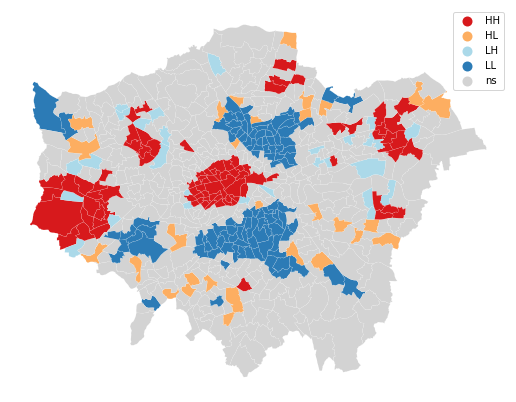

In [34]:
y_16 = warddata_16_m['percent'].values
# w = lps.weights.distance.Kernel.from_dataframe(gdf_drop, fixed=False, k=15)

moran_loc_16 = Moran_Local(y_16, wq)
loc_moran_df_16 = pd.DataFrame({'name':warddata_16_m.GSS_CODE, 'loc_moran':moran_loc_16.Is}) # moran_loc.Is
fig, ax = lisa_cluster(moran_loc, warddata_m, p=0.1, figsize = (9,9))

### 5.4Mapping

Create a-b map.

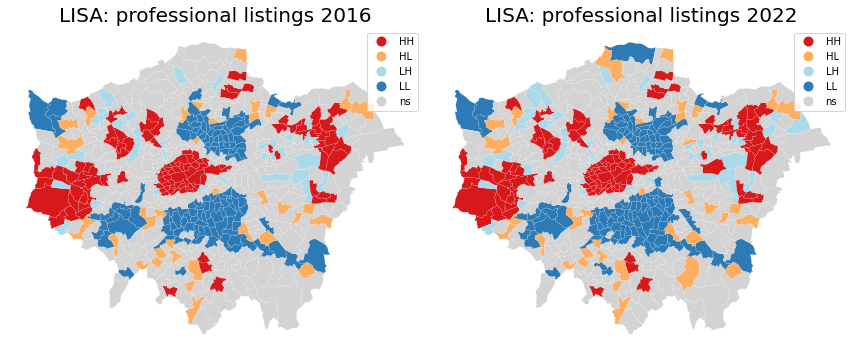

In [35]:
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Make the axes accessible with single indexing
axs = axs.flatten()

esdaplot.lisa_cluster(moran_loc, warddata_m, p=0.15, ax=axs[0])
esdaplot.lisa_cluster(moran_loc_16, warddata_16_m, p=0.15, ax=axs[1])

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "LISA: professional listings 2016",
            "LISA: professional listings 2022",
        ][i],
        y=1,fontsize=20
    )

# Tight layout to minimise in-betwee white space
f.tight_layout()
plt.show()
# Set title to each subplot